[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/it-threat-detection.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/docs/it-threat-detection.ipynb)

## IT Threat Detection With Similarity Search

[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/full-link.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/security/it-threat-detection.ipynb)

This notebook shows how to use Pinecone's similarity search as a service to build an application for detecting rare events. Such application is common in cyber-security and fraud detection domains wherein only a tiny fraction of the events are malicious.

Here we will build a network intrusion detector. Network intrusion detection systems monitor incoming and outgoing network traffic flow, raising alarms whenever a threat is detected. Here we use a deep-learning model and similarity search in detecting and classifying network intrusion traffic.

We will start by indexing a set of labeled traffic events in the form of vector embeddings. Each event is either benign or malicious. The vector embeddings are rich, mathematical representations of the network traffic events. It is making it possible to determine how similar the network events are to one another using similarity-search algorithms built into Pinecone. Here we will transform network traffic events into vectors using a deep learning model from recent academic work.


We will then take some new (unseen) network events and search through the index to find the most similar matches, along with their labels. In such a way, we will propagate the matched labels to classify the unseen events as benign or malicious. Mind that the intrusion detection task is a challenging classification task because malicious events are sporadic. The similarity search service helps us sift the most relevant historical labeled events. That way, we identify these rare events while keeping a low rate of false alarms.


## Setting up Pinecone

We will first install and initialize Pinecone. You can get your [API Key here](https://app.pinecone.io).

In [1]:
!pip install -qU \
  "pinecone-client[grpc]"==2.2.2 \
  pinecone-datasets=='0.5.0rc10'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pinecone
import os

# Load Pinecone API key
api_key = os.environ.get('PINECONE_API_KEY') or 'PINECONE_API_KEY'
# Set Pinecone environment/region - find next to API key in console
env = os.environ.get('PINECONE_ENVIRONMENT') or 'PINECONE_ENVIRONMENT'

pinecone.init(api_key=api_key, environment=env)

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
#List all present indexes associated with your key, should be empty on the first run
pinecone.list_indexes()

['it-threats-fast']

## Installing other dependencies

In [4]:
!pip install -qU \
  python-dateutil \
  tensorflow==2.10 \
  scikit-learn==1.3.0 \
  matplotlib==3.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 26.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.1 which is incompatible.


## Define a New Pinecone Index

In [5]:
# Pick a name for the new service
index_name = 'it-threats-fast'

In [6]:
# Make sure index with the same name does not exist
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

**Create an index**

In [7]:
pinecone.create_index(name=index_name, dimension=128, metric='euclidean')

**Connect to the index**

We create an index object, a class instance of `pinecone.GRPCIndex`, which will be used to interact with the created index.

In [8]:
index = pinecone.GRPCIndex(index_name=index_name)

## Upload
Here we load network events as precomputed vector embeddings from `pinecone-datasets` library, then upload them into Pinecone's vector index.

### Download Data

**Download data for 22-02-2018 and 23-02-2018**




In [18]:
from pinecone_datasets import load_dataset

dataset = load_dataset("it-threat-data-train")
dataset.head()

,id,values,sparse_values,metadata,blob
0,Ben_0,"[0.0, 0.0, 0.0, 125628656.0, 0.0, 0.0, 5421442...",None,{'label': 'Benign'},None
1,Ben_1,"[0.0, 0.0, 0.0, 356751744.0, 1190461440.0, 0.0...",None,{'label': 'Benign'},None
2,Ben_2,"[0.0, 0.0, 0.0, 356751680.0, 1190461440.0, 0.0...",None,{'label': 'Benign'},None
3,Ben_3,"[0.0, 0.0, 0.0, 125515856.0, 0.0, 0.0, 5432884...",None,{'label': 'Benign'},None
4,Ben_4,"[0.0, 0.0, 0.0, 26214912.0, 698683840.0, 0.0, ...",None,{'label': 'Benign'},None


We don't need the `sparse_values` and `blob` columns so we drop:

In [19]:
dataset.documents.drop(['sparse_values', 'blob'], axis=1, inplace=True)
dataset.head()

,id,values,metadata
0,Ben_0,"[0.0, 0.0, 0.0, 125628656.0, 0.0, 0.0, 5421442...",{'label': 'Benign'}
1,Ben_1,"[0.0, 0.0, 0.0, 356751744.0, 1190461440.0, 0.0...",{'label': 'Benign'}
2,Ben_2,"[0.0, 0.0, 0.0, 356751680.0, 1190461440.0, 0.0...",{'label': 'Benign'}
3,Ben_3,"[0.0, 0.0, 0.0, 125515856.0, 0.0, 0.0, 5432884...",{'label': 'Benign'}
4,Ben_4,"[0.0, 0.0, 0.0, 26214912.0, 698683840.0, 0.0, ...",{'label': 'Benign'}


### Upload Data

You can lower the `num_items` and, by doing so, limit the number of uploaded items.

In [20]:
dataset.head()

,id,values,metadata
0,Ben_0,"[0.0, 0.0, 0.0, 125628656.0, 0.0, 0.0, 5421442...",{'label': 'Benign'}
1,Ben_1,"[0.0, 0.0, 0.0, 356751744.0, 1190461440.0, 0.0...",{'label': 'Benign'}
2,Ben_2,"[0.0, 0.0, 0.0, 356751680.0, 1190461440.0, 0.0...",{'label': 'Benign'}
3,Ben_3,"[0.0, 0.0, 0.0, 125515856.0, 0.0, 0.0, 5432884...",{'label': 'Benign'}
4,Ben_4,"[0.0, 0.0, 0.0, 26214912.0, 698683840.0, 0.0, ...",{'label': 'Benign'}


In [21]:
num_items = 50_000
dataset = dataset.documents[:num_items]

index.upsert_from_dataframe(dataset, batch_size=500)

sending upsert requests:   0%|          | 0/50000 [00:00<?, ?it/s]

collecting async responses:   0%|          | 0/100 [00:00<?, ?it/s]

upserted_count: 50000

Let's verify all items were inserted.

In [22]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.5,
 'namespaces': {'': {'vector_count': 50000}},
 'total_vector_count': 50000}

## Query

First, we will randomly select a Benign/Attack event and query the vector index using the event embedding. Then, we will use data from different day, that contains same set of attacks to query on a bigger sample.

### Load the Model

Here we load the pretrained model. The model is trained using the data from the same date.

We have modified [the original model](https://github.com/rambasnet/DeepLearning-IDS/blob/master/keras_tensorflow_models/02-23-2018.csv_adam_10_10_multiclass_baseline_model_1561316601.model) slightly and changed the number of classes from four (Benign, BruteForce-Web, BruteForce-XSS, SQL-Injection) to two (Benign and Attack). In the step below we will download and unzip our modified model.

In [23]:
!wget -q -O it_threat_model.model.zip "https://drive.google.com/uc?export=download&id=1VYMHOk_XMAc-QFJ_8CAPvWFfHnLpS2J_"
!unzip -q it_threat_model.model.zip

In [24]:
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [25]:
model = keras.models.load_model('it_threat_model.model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               10240     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,561
Trainable params: 18,561
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Select the first layer
layer_name = 'dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


### Evaluate the Rare Event Classification Model

We will use network intrusion precomputed dataset for 22-02-2018 for querying and testing the Pinecone.

In [27]:
dataset_22 = load_dataset("it-threat-data-test")
dataset_22.head()

,id,values,sparse_values,metadata,blob
0,Ben_0,"[0.0, 0.0, 0.0, 170976752.0, 187935920.0, 0.0,...",None,{'label': 'Benign'},None
1,Ben_1,"[0.0, 0.0, 0.0, 211572592.0, 0.0, 0.0, 7663978...",None,{'label': 'Benign'},None
2,Ben_2,"[0.0, 0.0, 0.0, 133747560.0, 770489344.0, 0.0,...",None,{'label': 'Benign'},None
3,Ben_3,"[0.0, 0.0, 0.0, 133747288.0, 770489344.0, 0.0,...",None,{'label': 'Benign'},None
4,Ben_4,"[0.0, 0.0, 0.0, 26222988.0, 698676736.0, 0.0, ...",None,{'label': 'Benign'},None


In [28]:
dataset_22.documents.drop(['sparse_values', 'blob'], axis=1, inplace=True)
dataset_22.head()

,id,values,metadata
0,Ben_0,"[0.0, 0.0, 0.0, 170976752.0, 187935920.0, 0.0,...",{'label': 'Benign'}
1,Ben_1,"[0.0, 0.0, 0.0, 211572592.0, 0.0, 0.0, 7663978...",{'label': 'Benign'}
2,Ben_2,"[0.0, 0.0, 0.0, 133747560.0, 770489344.0, 0.0,...",{'label': 'Benign'}
3,Ben_3,"[0.0, 0.0, 0.0, 133747288.0, 770489344.0, 0.0,...",{'label': 'Benign'}
4,Ben_4,"[0.0, 0.0, 0.0, 26222988.0, 698676736.0, 0.0, ...",{'label': 'Benign'}


Let's define a sample that will include all different types of web attacks for this specific date.

In [29]:
data_sample = dataset_22.documents[-2000:]
data_sample.metadata.value_counts()

metadata
{'label': 'Benign'}              1638
{'label': 'Brute Force -Web'}     249
{'label': 'Brute Force -XSS'}      79
{'label': 'SQL Injection'}         34
Name: count, dtype: int64

Now, we will query the test dataset and save predicted and expected results to create a confusion matrix.

In [30]:
from tqdm.auto import tqdm
from collections import Counter

y_true = []
y_pred = []

BATCH_SIZE = 100

for i in tqdm(range(0, len(data_sample), BATCH_SIZE)):
    test_data = data_sample.iloc[i:i+BATCH_SIZE, :]
    test_vector = test_data['values'].tolist()

    # Query using the vector embedding
    query_results = []

    for xq in test_vector:
        query_res = index.query(xq.tolist(), top_k=50)
        query_results.append(query_res)

    ids = [res.id for result in query_results for res in result.matches]

    for label, res in zip(test_data.metadata.values, query_results):
        # Add to the true list
        if label['label'] == 'Benign':
            y_true.append(0)
        else:
            y_true.append(1)

        counter = Counter(match.id.split('_')[0] for match in res.matches)

        # Add to the predicted list
        if counter['Bru'] or counter['SQL']:
            y_pred.append(1)
        else:
            y_pred.append(0)


  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
!pip install seaborn -qU

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0, 0.5, 'Benign'), Text(0, 1.5, 'Attack')]

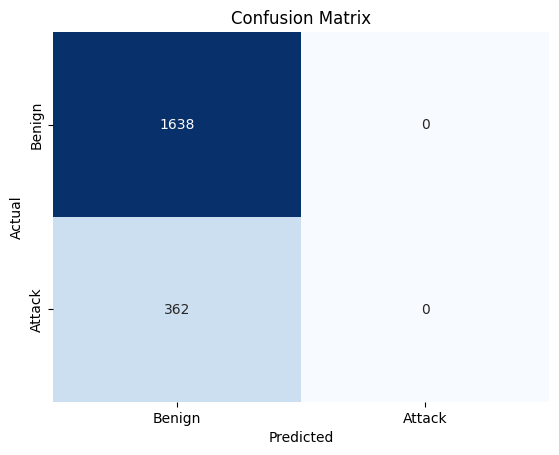

In [33]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show confusion matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap='Blues', fmt='g', cbar=False)

# Add labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Benign', 'Attack'])
ax.yaxis.set_ticklabels(['Benign', 'Attack'])

Now we can calculate overall accuracy and per class accuracy.

In [34]:
# Calculate accuracy
acc = accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.819
Precision: 0.000
Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
import pandas as pd

# Calculate per class accuracy
cmd = confusion_matrix(y_true, y_pred, normalize="true").diagonal()
per_class_accuracy_df = pd.DataFrame([(index, round(value,4)) for index, value in zip(['Benign', 'Attack'], cmd)], columns = ['type', 'accuracy'])
per_class_accuracy_df = per_class_accuracy_df.round(2)
display(per_class_accuracy_df)

,type,accuracy
0,Benign,1.0
1,Attack,0.0


We got great results using Pinecone! In [our longer example](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/security/it-threat-detection.ipynb) we also see what happens if we skip the similarity search step and predict values from the model directly. In short, it performs much worse! By adding Pinecone's similarity search over the same model's embeddings we improve threat detection (i.e., "Attack") accuracy by over 50%!

### Result summary

Using standard vector embeddings with Pinecone's similarity search service, we detected 85% of the attacks while keeping a low 3% false-positive rate. In [our longer example](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/security/it-threat-detection.ipynb), we also showed that our similarity search approach outperforms the direct classification approach that utilizes the classifier's embedding model. Similarity search-based detection gained 50% higher accuracy compared to the direct detector.

[Original published results](https://github.com/rambasnet/DeepLearning-IDS/blob/master/graphics/confusion_matrices/) for 02-22-2018 show that the model was able to correctly detect 208520 benign cases out of 208520 benign cases, and 24 (18+1+5) attacks out of 70 attacks in the test set making this model **34.3% accurate in predicting attacks**. For testing purposes, 20% of the data for 02-22-2018 was used.

![02-22-2018--6-15%281%29.png](https://raw.githubusercontent.com/rambasnet/DeepLearning-IDS/master/graphics/confusion_matrices/02-22-2018--6-15(1).png)

As you can see, the model's performance for creating embeddings for Pinecone was much higher.

The model we have created follows the academic paper ([model for the same date](https://github.com/rambasnet/DeepLearning-IDS/blob/master/keras_tensorflow_models/) (02-23-2018)) and is slightly modified, but still a straightforward, sequential, shallow model. We have changed the number of classes from four (Benign, BruteForce-Web, BruteForce-XSS, SQL-Injection) to two (Benign and Attack), only interested in whether we are detecting an attack or not. We have also changed validation metrics to precision and recall. These changes improved our results. Yet, there is still room for further improvements, for example, by adding more data covering multiple days and different types of attacks.

## Delete the Index

Delete the index once you are sure that you do not want to use it anymore. Once it is deleted, you cannot reuse it.

In [ ]:
pinecone.delete_index(index_name)

---